<a href="https://colab.research.google.com/github/kareemullah123456789/CNN-AI/blob/main/download_CNN_CaseStudy_ChestXRay_CustomDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Case Study: Chest X-Ray Pneumonia Detection (Custom Dataset Pipeline)

**Goal:** Learn how to build a CNN pipeline from scratch using a real-world Kaggle dataset loaded from Google Drive.

Unlike previous notebooks that used pre-loaded Keras/TFDS datasets, this notebook covers the **full real-world workflow**:
loading raw images from disk, labeling them from folder names, validating for corruption, preprocessing, handling class imbalance, and training.

---

**Dataset:** [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) from Kaggle
- ~5,856 chest X-ray images
- 2 classes: **NORMAL** and **PNEUMONIA**
- Images are variable size, grayscale X-rays stored as RGB

---

### Table of Contents

1. Setup: Mount Google Drive & Imports
2. Explore Dataset Folder Structure
3. Collect Image Paths & Assign Labels from Folder Names
4. Validate Images (Handle Corrupted Files)
5. Load, Resize & Normalize Images
6. Train / Validation / Test Split
7. Visualize Samples
8. Class Imbalance Analysis & Class Weights
9. Data Augmentation
10. Model 1: Baseline CNN
11. Model 2: Improved CNN (BN + Dropout + Augmentation + Class Weights)
12. Training History Comparison
13. Confusion Matrix & Classification Report
14. Error Analysis
15. Conclusion

---

### How to Get the Dataset

1. Go to [Kaggle: Chest X-Ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
2. Click **Download** (you need a free Kaggle account)
3. Extract the zip file - you will get a folder called `chest_xray`
4. Upload the entire `chest_xray` folder to your **Google Drive** (root level: `MyDrive/chest_xray/`)

Expected folder structure on Drive:
```
MyDrive/
  chest_xray/
    train/
      NORMAL/       (~1,341 images)
      PNEUMONIA/    (~3,875 images)
    val/
      NORMAL/       (8 images)
      PNEUMONIA/    (8 images)
    test/
      NORMAL/       (~234 images)
      PNEUMONIA/    (~390 images)
```

## 1. Setup: Mount Google Drive & Imports

In [1]:
# Mount Google Drive to access the dataset
# A popup will ask you to authorize access - click Allow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pwd

'/content'

In [5]:
ls /content/drive/MyDrive/  | grep -i xrays

xrays.zip


In [6]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/xrays.zip'
extract_path = '/content/chest_xray_data'

if not os.path.exists(extract_path):
    print('Extracting...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print('Done!')
else:
    print('Already extracted')

# See what's inside
for item in os.listdir(extract_path):
    print(f'  {item}')

Extracting...
Done!
  chest_xray


In [7]:
import os                                          # file/folder operations
import numpy as np                                 # array operations
import matplotlib.pyplot as plt                    # plotting
import cv2                                         # image loading and resizing
from PIL import Image                              # image validation
import tensorflow as tf                            # deep learning framework
from tensorflow import keras                       # high-level API
from tensorflow.keras import layers, models        # CNN building blocks
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # augmentation
from sklearn.model_selection import train_test_split                 # splitting
from sklearn.utils.class_weight import compute_class_weight          # class imbalance
from sklearn.metrics import classification_report, confusion_matrix  # evaluation
from sklearn.metrics import ConfusionMatrixDisplay                   # confusion matrix plot
import warnings
warnings.filterwarnings('ignore')

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow version: 2.19.0
GPU available: False


## 2. Explore Dataset Folder Structure

Before loading any images, we first explore what is on disk.
This is a critical step with any custom dataset - you need to understand the folder layout, class names, and image counts before writing any loading code.

In [8]:
# -----------------------------------------------------------
# Point to the dataset folder on Google Drive
# Change this path if your folder is in a different location
# -----------------------------------------------------------
dataset_path = '/content/chest_xray_data/chest_xray'

# Walk through and count images in each subfolder
print('Dataset Folder Structure')
print('=' * 55)
total_images = 0

for split_name in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split_name)

    # Check if this split folder exists
    if not os.path.isdir(split_path):
        print(f'  {split_name}/  -> NOT FOUND')
        continue

    print(f'  {split_name}/')

    # List class subfolders inside this split
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)

        # Skip files, only process folders
        if not os.path.isdir(class_path):
            continue

        # Count files (skip hidden files like .DS_Store)
        file_count = 0
        for fname in os.listdir(class_path):
            if not fname.startswith('.'):
                file_count += 1

        print(f'    {class_name:15s} -> {file_count:5d} images')
        total_images += file_count

print(f'\nTotal images across all splits: {total_images}')
print(f'\nNotice: The original val/ split has only 16 images!')
print(f'This is too small for reliable validation.')
print(f'We will combine ALL images and create our own 70/15/15 split.')

Dataset Folder Structure
  train/
    NORMAL          ->  1341 images
    PNEUMONIA       ->  3875 images
  val/
    NORMAL          ->     8 images
    PNEUMONIA       ->     8 images
  test/
    NORMAL          ->   234 images
    PNEUMONIA       ->   390 images

Total images across all splits: 5856

Notice: The original val/ split has only 16 images!
This is too small for reliable validation.
We will combine ALL images and create our own 70/15/15 split.


## 3. Collect Image Paths & Assign Labels from Folder Names

**Key concept:** The folder name IS the label.
- Files inside `NORMAL/` get label **0**
- Files inside `PNEUMONIA/` get label **1**

This is the most common way to organize image datasets. No separate CSV or annotation file is needed - the directory structure itself encodes the labels.

We combine images from ALL splits (train + val + test) into one pool, then re-split ourselves.

In [9]:
# -----------------------------------------------------------
# Label mapping: folder name -> integer
# -----------------------------------------------------------
class_names = ['NORMAL', 'PNEUMONIA']   # index 0, index 1

all_paths = []       # will hold full file paths
all_labels = []      # will hold integer labels (0 or 1)

# Loop through every split folder (train, val, test)
for split_name in ['train', 'val', 'test']:
    split_path = os.path.join(dataset_path, split_name)

    # Skip if split folder does not exist
    if not os.path.isdir(split_path):
        continue

    # Loop through each class folder inside the split
    for class_idx in range(len(class_names)):
        class_name = class_names[class_idx]
        class_path = os.path.join(split_path, class_name)

        # Skip if class folder does not exist
        if not os.path.isdir(class_path):
            continue

        # Collect every file in this class folder
        for filename in os.listdir(class_path):
            # Skip hidden files (e.g., .DS_Store on Mac)
            if filename.startswith('.'):
                continue

            file_path = os.path.join(class_path, filename)

            # Only collect files, not subdirectories
            if os.path.isfile(file_path):
                all_paths.append(file_path)
                all_labels.append(class_idx)   # label = folder index

print(f'Collected {len(all_paths)} image paths')
print(f'  NORMAL (0):    {all_labels.count(0)}')
print(f'  PNEUMONIA (1): {all_labels.count(1)}')
print(f'\nFirst 3 paths (to verify):')
for i in range(3):
    print(f'  [{all_labels[i]}] {all_paths[i]}')

Collected 5856 image paths
  NORMAL (0):    1583
  PNEUMONIA (1): 4273

First 3 paths (to verify):
  [0] /content/chest_xray_data/chest_xray/train/NORMAL/IM-0684-0001.jpeg
  [0] /content/chest_xray_data/chest_xray/train/NORMAL/IM-0636-0001.jpeg
  [0] /content/chest_xray_data/chest_xray/train/NORMAL/NORMAL2-IM-1128-0001-0002.jpeg


In [11]:
all_labels[:6]

[0, 0, 0, 0, 0, 0]

In [10]:
all_paths[:5]

['/content/chest_xray_data/chest_xray/train/NORMAL/IM-0684-0001.jpeg',
 '/content/chest_xray_data/chest_xray/train/NORMAL/IM-0636-0001.jpeg',
 '/content/chest_xray_data/chest_xray/train/NORMAL/NORMAL2-IM-1128-0001-0002.jpeg',
 '/content/chest_xray_data/chest_xray/train/NORMAL/NORMAL2-IM-0922-0001.jpeg',
 '/content/chest_xray_data/chest_xray/train/NORMAL/NORMAL2-IM-0462-0001.jpeg']

## 4. Validate Images (Handle Corrupted Files)

Real-world datasets often contain:
- **Truncated files** - download was interrupted
- **Zero-byte files** - empty placeholder
- **Non-image files** - text files, thumbnails, system files
- **Unreadable formats** - corrupted headers

We run 4 checks on every file before including it:
1. **File size check** - skip files smaller than 100 bytes
2. **PIL verify** - checks image header integrity
3. **PIL read** - checks that pixel data can actually be loaded
4. **Dimension check** - skip images smaller than 10x10 pixels

In [12]:
# -----------------------------------------------------------
# Validate every image file before loading
# -----------------------------------------------------------
valid_paths = []
valid_labels = []
corrupted_files = []

for i in range(len(all_paths)):
    path = all_paths[i]
    label = all_labels[i]

    try:
        # Check 1: File size - skip tiny/empty files
        file_size = os.path.getsize(path)
        if file_size < 100:    # less than 100 bytes is suspicious
            corrupted_files.append((path, f'Too small: {file_size} bytes'))
            continue

        # Check 2: PIL verify - checks image header integrity
        # verify() does not load pixel data, only checks metadata
        img = Image.open(path)
        img.verify()

        # Check 3: PIL read - actually load pixel data
        # verify() closes the file, so we reopen it
        img = Image.open(path)
        img_array = np.array(img)

        # Check 4: Minimum dimensions - skip tiny images
        if img_array.shape[0] < 10 or img_array.shape[1] < 10:
            corrupted_files.append((path, f'Too small: {img_array.shape}'))
            continue

        # Image passed all checks
        valid_paths.append(path)
        valid_labels.append(label)

    except Exception as e:
        corrupted_files.append((path, str(e)))

print(f'Validation results:')
print(f'  Valid images:     {len(valid_paths)}')
print(f'  Corrupted/invalid: {len(corrupted_files)}')

# Show corrupted files if any were found
if len(corrupted_files) > 0:
    print(f'\nCorrupted files (showing first 10):')
    for j in range(min(10, len(corrupted_files))):
        filepath, reason = corrupted_files[j]
        print(f'  {os.path.basename(filepath)} -> {reason}')
else:
    print('\nNo corrupted files found - dataset is clean!')

Validation results:
  Valid images:     5856
  Corrupted/invalid: 0

No corrupted files found - dataset is clean!


In [13]:
# Check a few sample image sizes (before resize)
print('Sample image dimensions (original sizes):')
for i in range(min(5, len(valid_paths))):
    img = Image.open(valid_paths[i])
    w, h = img.size
    print(f'  [{class_names[valid_labels[i]]}] {os.path.basename(valid_paths[i])}: {w}x{h} px, mode={img.mode}')

Sample image dimensions (original sizes):
  [NORMAL] IM-0684-0001.jpeg: 2078x1801 px, mode=L
  [NORMAL] IM-0636-0001.jpeg: 1766x1611 px, mode=L
  [NORMAL] NORMAL2-IM-1128-0001-0002.jpeg: 1414x1164 px, mode=L
  [NORMAL] NORMAL2-IM-0922-0001.jpeg: 1508x1140 px, mode=L
  [NORMAL] NORMAL2-IM-0462-0001.jpeg: 1684x1240 px, mode=L


## 5. Load, Resize & Normalize Images

Now we load the actual pixel data:
1. **Read** each image using OpenCV
2. **Convert BGR to RGB** (OpenCV loads in BGR order, but we display/train in RGB)
3. **Resize** all images to 150x150 pixels (uniform size required by CNN)
4. **Normalize** pixel values from [0, 255] to [0.0, 1.0]

In [14]:
# -----------------------------------------------------------
# Load all valid images and resize to 150x150
# -----------------------------------------------------------
IMG_SIZE = 150   # target size (good balance: detail vs speed)

images = []      # will hold pixel arrays
labels = []      # will hold integer labels

for i in range(len(valid_paths)):
    path = valid_paths[i]
    label = valid_labels[i]

    # Read image with OpenCV (loads as BGR, 3 channels)
    img = cv2.imread(path)

    # cv2.imread returns None if file cannot be decoded
    if img is None:
        continue

    # Convert BGR (OpenCV default) to RGB (standard)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to uniform dimensions
    # cv2.resize uses bilinear interpolation by default
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    images.append(img)
    labels.append(label)

    # Print progress every 1000 images
    if (i + 1) % 1000 == 0:
        print(f'  Loaded {i + 1}/{len(valid_paths)} images...')

# Convert Python lists to numpy arrays
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)   # float for binary_crossentropy

print(f'\nDataset loaded:')
print(f'  Shape:  {images.shape}')          # (N, 150, 150, 3)
print(f'  Labels: {labels.shape}')          # (N,)
print(f'  Memory: {images.nbytes / 1024 / 1024:.1f} MB')
print(f'  Pixels: [{images.min():.0f}, {images.max():.0f}]')

  Loaded 1000/5856 images...
  Loaded 2000/5856 images...
  Loaded 3000/5856 images...
  Loaded 4000/5856 images...
  Loaded 5000/5856 images...

Dataset loaded:
  Shape:  (5856, 150, 150, 3)
  Labels: (5856,)
  Memory: 1507.9 MB
  Pixels: [0, 255]


In [15]:
# -----------------------------------------------------------
# Normalize: [0, 255] -> [0.0, 1.0]
# Neural networks train faster with small input values
# -----------------------------------------------------------
images = images / 255.0

print(f'After normalization:')
print(f'  Pixel range: [{images.min():.2f}, {images.max():.2f}]')
print(f'  Mean pixel:  {images.mean():.4f}')
print(f'  Std pixel:   {images.std():.4f}')

After normalization:
  Pixel range: [0.00, 1.00]
  Mean pixel:  0.4811
  Std pixel:   0.2374


## 6. Train / Validation / Test Split

The original Kaggle dataset has a poor split (only 16 validation images!).
We combine everything and create a proper **70% / 15% / 15%** split.

**Key parameter: `stratify=labels`** - ensures each split has the **same class ratio** as the original dataset.
Without stratify, random splitting could put most NORMAL images in one split and most PNEUMONIA in another.

**Two-step splitting:**
- Step 1: 70% train, 30% temporary
- Step 2: Split temporary 50/50 into 15% val + 15% test

In [16]:
# -----------------------------------------------------------
# Step 1: Split 70% train vs 30% temp
# -----------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.30,          # 30% held out
    random_state=42,         # reproducible result
    stratify=labels          # keep NORMAL/PNEUMONIA ratio
)

# -----------------------------------------------------------
# Step 2: Split the 30% into 15% val + 15% test
# -----------------------------------------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,          # 50% of 30% = 15% of total
    random_state=42,
    stratify=y_temp
)

# Free memory - we no longer need the full arrays
images = None
labels = None
X_temp = None
y_temp = None

print('Split results:')
print(f'  Train:      {X_train.shape[0]:5d} images  '
      f'(NORMAL: {int((y_train==0).sum())}, PNEUMONIA: {int((y_train==1).sum())})')
print(f'  Validation: {X_val.shape[0]:5d} images  '
      f'(NORMAL: {int((y_val==0).sum())}, PNEUMONIA: {int((y_val==1).sum())})')
print(f'  Test:       {X_test.shape[0]:5d} images  '
      f'(NORMAL: {int((y_test==0).sum())}, PNEUMONIA: {int((y_test==1).sum())})')

Split results:
  Train:       4099 images  (NORMAL: 1108, PNEUMONIA: 2991)
  Validation:   878 images  (NORMAL: 237, PNEUMONIA: 641)
  Test:         879 images  (NORMAL: 238, PNEUMONIA: 641)


## 7. Visualize Samples

Always look at your data before training. This helps verify:
- Images loaded correctly (not blank, not corrupted)
- Labels are correct (NORMAL images look normal, PNEUMONIA images show opacity)
- Resize did not distort the images badly

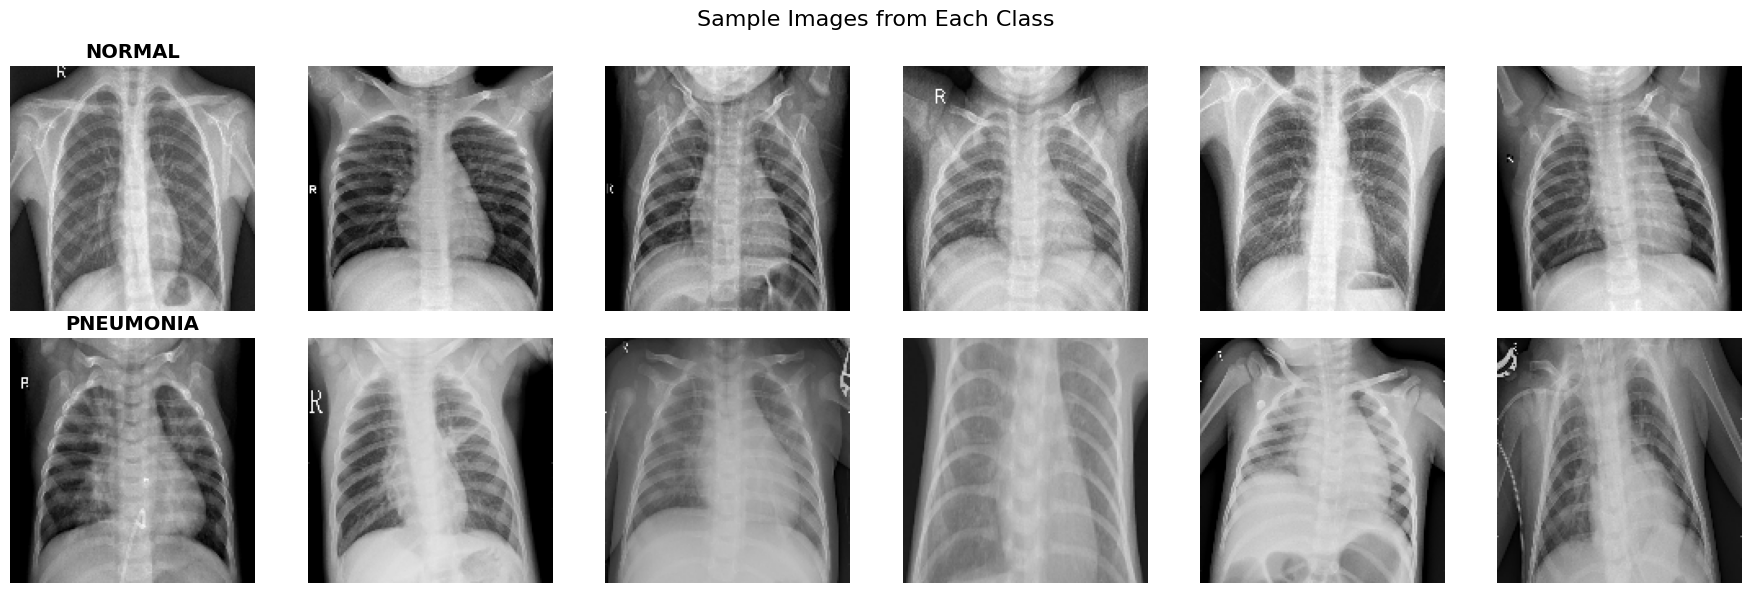

In [17]:
# -----------------------------------------------------------
# Display 6 random samples from each class
# -----------------------------------------------------------
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

np.random.seed(42)    # reproducible selection

for row in range(2):
    # Get indices where label matches this class
    class_idx = row      # row 0 = NORMAL (0), row 1 = PNEUMONIA (1)
    matching_indices = np.where(y_train == class_idx)[0]

    # Pick 6 random samples
    chosen = np.random.choice(matching_indices, size=6, replace=False)

    for col in range(6):
        axes[row, col].imshow(X_train[chosen[col]])
        axes[row, col].axis('off')

        # Only label the first column
        if col == 0:
            axes[row, col].set_title(
                class_names[class_idx], fontsize=14, fontweight='bold'
            )

plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Class Imbalance Analysis & Class Weights

The Chest X-Ray dataset is **imbalanced**: ~75% PNEUMONIA, ~25% NORMAL.

**Problem:** Without correction, the model can achieve ~75% accuracy by **always predicting PNEUMONIA** and never learning to detect NORMAL cases.

**Solution: Class weights** - tell the loss function to penalize mistakes on the minority class (NORMAL) more heavily.

- `class_weight='balanced'` computes: weight = total_samples / (num_classes * class_count)
- Minority class gets a higher weight -> higher penalty for getting it wrong
- Majority class gets a lower weight -> lower penalty

Training set class counts:
  NORMAL:    1108
  PNEUMONIA: 2991
  Imbalance ratio: 2.70:1 (Pneumonia vs Normal)

Computed class weights:
  NORMAL (0):    1.8497  (boosted - minority class)
  PNEUMONIA (1): 0.6852  (reduced - majority class)


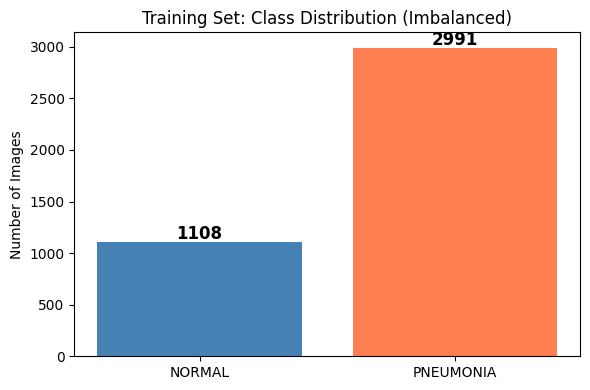

In [18]:
# -----------------------------------------------------------
# Analyze class distribution in training set
# -----------------------------------------------------------
normal_count = int((y_train == 0).sum())
pneumonia_count = int((y_train == 1).sum())
ratio = pneumonia_count / normal_count

print('Training set class counts:')
print(f'  NORMAL:    {normal_count}')
print(f'  PNEUMONIA: {pneumonia_count}')
print(f'  Imbalance ratio: {ratio:.2f}:1 (Pneumonia vs Normal)')

# -----------------------------------------------------------
# Compute class weights to balance the loss function
# Formula: weight_i = total / (num_classes * count_i)
# -----------------------------------------------------------
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0.0, 1.0]),
    y=y_train
)

# Convert to dictionary format that Keras expects
class_weight_dict = {0: weights[0], 1: weights[1]}

print(f'\nComputed class weights:')
print(f'  NORMAL (0):    {weights[0]:.4f}  (boosted - minority class)')
print(f'  PNEUMONIA (1): {weights[1]:.4f}  (reduced - majority class)')

# -----------------------------------------------------------
# Visualize the imbalance
# -----------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bars = ax.bar(class_names, [normal_count, pneumonia_count],
              color=['steelblue', 'coral'])
ax.set_ylabel('Number of Images')
ax.set_title('Training Set: Class Distribution (Imbalanced)')

# Add count labels on top of bars
for bar_idx in range(2):
    count = [normal_count, pneumonia_count][bar_idx]
    ax.text(bars[bar_idx].get_x() + bars[bar_idx].get_width() / 2,
            bars[bar_idx].get_height() + 30,
            str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Data Augmentation

Creates random variations of training images **on-the-fly** during training.
- Does NOT add more images (dataset size stays the same)
- Each epoch, the same images get different random transforms
- Only applied to **training** data (validation and test are never augmented)

Augmentation is especially important here because:
1. We have a relatively small dataset (~4,000 training images)
2. X-ray images can be slightly rotated, shifted, or zoomed in real life

In [19]:
# -----------------------------------------------------------
# Configure augmentation transforms
# -----------------------------------------------------------
train_datagen = ImageDataGenerator(
    rotation_range=10,           # rotate up to +/- 10 degrees
    width_shift_range=0.1,       # shift left/right up to 10%
    height_shift_range=0.1,      # shift up/down up to 10%
    zoom_range=0.1,              # zoom in/out up to 10%
    horizontal_flip=False,       # chest X-rays should NOT be flipped
    fill_mode='nearest'          # fill new pixels with nearest neighbor
)

# Note: horizontal_flip=False because flipping a chest X-ray
# would reverse the heart position (dextrocardia), which is
# a separate medical condition - not a valid augmentation here

# Fit on training data (computes statistics for some transforms)
train_datagen.fit(X_train)

# Create the batch generator
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

print(f'Augmentation configured')
print(f'Training images: {X_train.shape[0]}')
print(f'Batches per epoch: {X_train.shape[0] // 32}')

Augmentation configured
Training images: 4099
Batches per epoch: 128


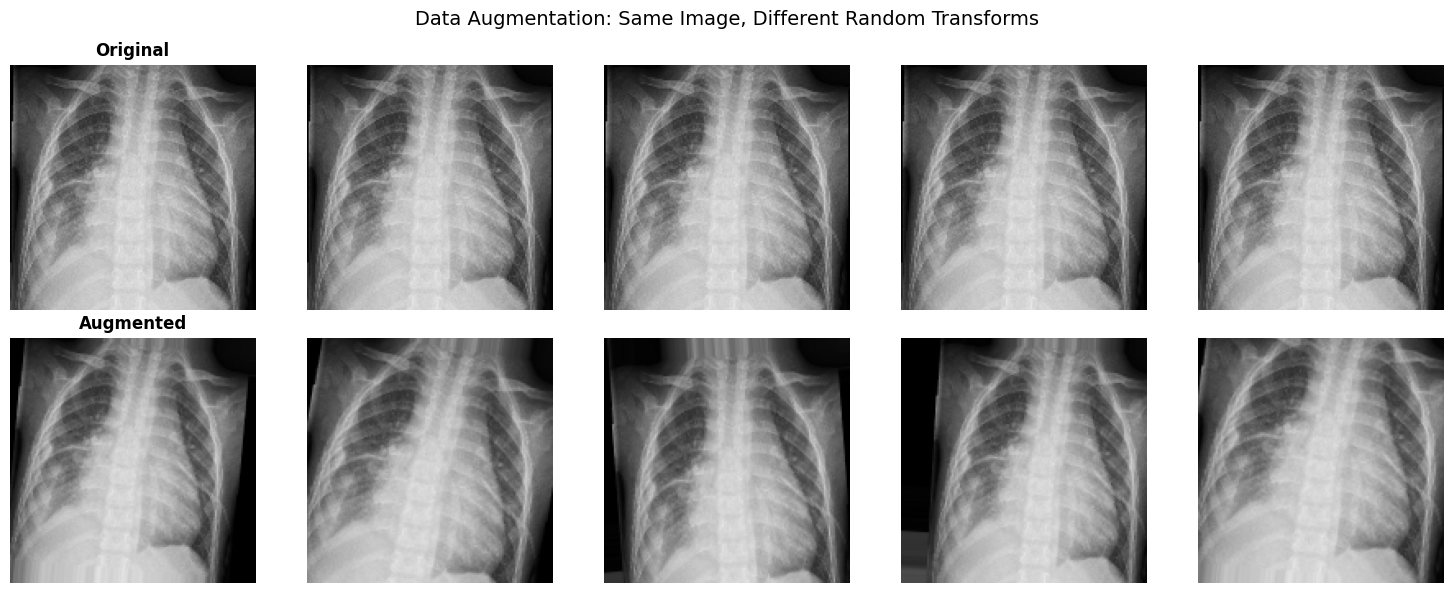

In [20]:
# -----------------------------------------------------------
# Visualize: original vs augmented versions of the same image
# -----------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: same original image repeated
original_img = X_train[0]
for col in range(5):
    axes[0, col].imshow(original_img)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_title('Original', fontsize=12, fontweight='bold')

# Bottom row: different augmented versions of that image
single_gen = train_datagen.flow(
    X_train[0:1], y_train[0:1],   # pass single image
    batch_size=1
)
for col in range(5):
    aug_batch = next(single_gen)    # get one augmented version
    axes[1, col].imshow(aug_batch[0][0])
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_title('Augmented', fontsize=12, fontweight='bold')

plt.suptitle('Data Augmentation: Same Image, Different Random Transforms', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Model 1: Baseline CNN

A simple CNN with NO regularization (no BatchNorm, no Dropout, no augmentation, no class weights).

This establishes a **reference accuracy** so we can measure how much each technique helps.

Architecture:
- 3 conv blocks (32 -> 64 -> 128 filters)
- Flatten + Dense classifier
- **1 output neuron** with sigmoid (binary classification)

In [21]:
# -----------------------------------------------------------
# Build baseline CNN
# -----------------------------------------------------------
baseline_model = models.Sequential([
    # Block 1: 32 filters, 3x3 kernel
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),        # 150x150 -> 75x75

    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),        # 75x75 -> 37x37

    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),        # 37x37 -> 18x18

    # Classifier head
    layers.Flatten(),                   # 18*18*128 = 41,472 values
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 1 neuron for binary
])

# Compile with binary crossentropy (not categorical)
baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# -----------------------------------------------------------
# Train baseline: no augmentation, no class weights
# -----------------------------------------------------------
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

129/129 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9422 - loss: 0.1637 - val_accuracy: 0.8975 - val_loss: 0.2766


## 11. Model 2: Improved CNN (BN + Dropout + Augmentation + Class Weights)

Improvements over baseline:
- **BatchNormalization** after every Conv2D (stable training)
- **Dropout** after every block (prevents overfitting)
- **Two Conv2D layers per block** (deeper feature extraction)
- **GlobalAveragePooling2D** instead of Flatten (fewer parameters)
- Training with **augmented data** and **class weights**
- **EarlyStopping + ReduceLROnPlateau** callbacks

In [24]:
# -----------------------------------------------------------
# Build improved CNN with regularization
# -----------------------------------------------------------
improved_model = models.Sequential([
    # Block 1: 32 filters, two conv layers per block
    layers.Conv2D(32, (3, 3), padding='same',
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 150 -> 75
    layers.Dropout(0.25),               # drop 25% of neurons

    # Block 2: 64 filters
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 75 -> 37
    layers.Dropout(0.25),

    # Block 3: 128 filters
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),        # 37 -> 18
    layers.Dropout(0.25),

    # Classifier head with Global Average Pooling
    layers.GlobalAveragePooling2D(),    # 18x18x128 -> 128 values
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),               # strong dropout before output
    layers.Dense(1, activation='sigmoid')  # binary output
])

improved_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

improved_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 37, 37, 128)    │             

 Total params: 297,121 (1.13 MB)

 Trainable params: 296,225 (1.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [25]:
# -----------------------------------------------------------
# Callbacks: EarlyStopping + ReduceLROnPlateau
# -----------------------------------------------------------
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',           # watch validation loss
    patience=7,                   # wait 7 epochs before stopping
    restore_best_weights=True     # roll back to best epoch
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # watch validation loss
    factor=0.5,                   # halve LR when stuck
    patience=3,                   # wait 3 epochs before reducing
    min_lr=1e-6                   # never go below 0.000001
)

# -----------------------------------------------------------
# Train with augmentation + class weights + callbacks
# -----------------------------------------------------------
improved_history = improved_model.fit(
    train_generator,                        # augmented training batches
    steps_per_epoch=X_train.shape[0] // 32, # batches per epoch
    epochs=1,
    validation_data=(X_val, y_val),          # no augmentation for val
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weight_dict,          # handle imbalance
    verbose=1
)

128/128 ━━━━━━━━━━━━━━━━━━━━ 907s 7s/step - accuracy: 0.7845 - loss: 0.4282 - val_accuracy: 0.7301 - val_loss: 4.3806 - learning_rate: 0.0010


## 12. Training History Comparison

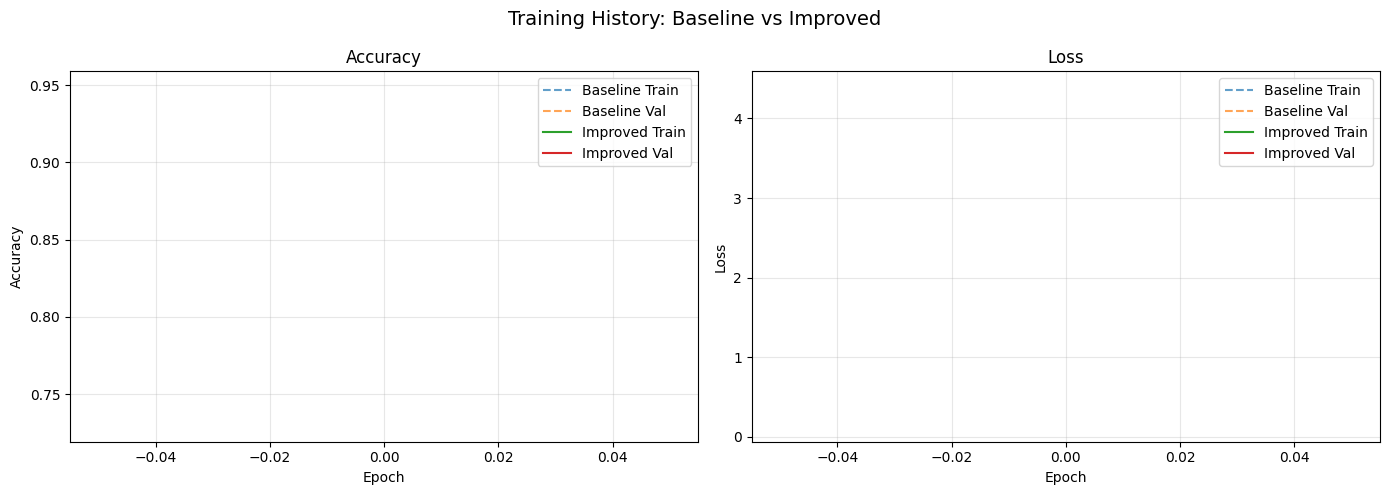

In [26]:
# -----------------------------------------------------------
# Plot accuracy and loss curves for both models
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Accuracy plot ---
axes[0].plot(baseline_history.history['accuracy'],
             label='Baseline Train', linestyle='--', alpha=0.7)
axes[0].plot(baseline_history.history['val_accuracy'],
             label='Baseline Val', linestyle='--', alpha=0.7)
axes[0].plot(improved_history.history['accuracy'],
             label='Improved Train')
axes[0].plot(improved_history.history['val_accuracy'],
             label='Improved Val')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Loss plot ---
axes[1].plot(baseline_history.history['loss'],
             label='Baseline Train', linestyle='--', alpha=0.7)
axes[1].plot(baseline_history.history['val_loss'],
             label='Baseline Val', linestyle='--', alpha=0.7)
axes[1].plot(improved_history.history['loss'],
             label='Improved Train')
axes[1].plot(improved_history.history['val_loss'],
             label='Improved Val')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History: Baseline vs Improved', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# -----------------------------------------------------------
# Test set evaluation
# -----------------------------------------------------------
print('Test Set Evaluation')
print('=' * 45)

baseline_loss, baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f'  Baseline:  Loss = {baseline_loss:.4f}   Accuracy = {baseline_acc:.4f}')

improved_loss, improved_acc = improved_model.evaluate(X_test, y_test, verbose=0)
print(f'  Improved:  Loss = {improved_loss:.4f}   Accuracy = {improved_acc:.4f}')

print(f'\n  Improvement: {(improved_acc - baseline_acc) * 100:+.2f}% accuracy')

Test Set Evaluation
  Baseline:  Loss = 0.2199   Accuracy = 0.9135
  Improved:  Loss = 4.3955   Accuracy = 0.7292

  Improvement: -18.43% accuracy


## 13. Confusion Matrix & Classification Report

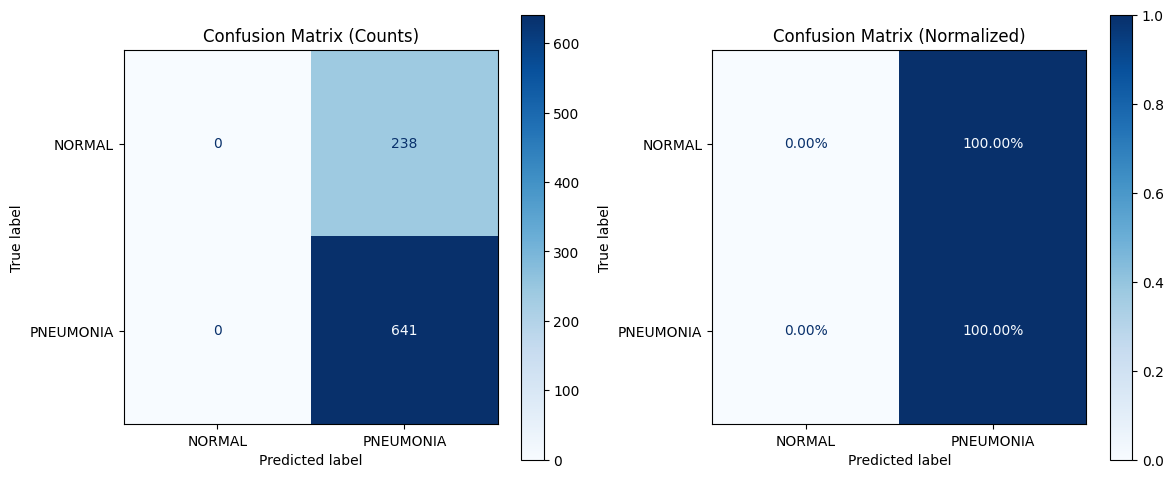

In [28]:
# -----------------------------------------------------------
# Get predictions from the improved model
# Sigmoid output > 0.5 = PNEUMONIA (1), else NORMAL (0)
# -----------------------------------------------------------
y_pred_probs = improved_model.predict(X_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# -----------------------------------------------------------
# Confusion Matrix: raw counts and normalized
# -----------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
disp1 = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized (percentages per true class)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------
# Classification Report: Precision, Recall, F1-Score per class
# -----------------------------------------------------------
print('Classification Report')
print('=' * 55)
print(classification_report(y_test, y_pred, target_names=class_names))

print('Key metrics for medical imaging:')
print('  Recall (PNEUMONIA) = Of all pneumonia cases, how many did we detect?')
print('  Precision (PNEUMONIA) = Of predicted pneumonia, how many actually have it?')
print('  In medicine, high RECALL is critical - missing a disease is worse than a false alarm.')

## 14. Error Analysis

Look at the images the model got wrong. This helps understand:
- Are the errors on ambiguous/hard images?
- Is the model systematically confusing one class?
- Could better preprocessing or more data help?

In [ ]:
# -----------------------------------------------------------
# Display misclassified images
# -----------------------------------------------------------
wrong_indices = np.where(y_pred != y_test.astype(int))[0]

print(f'Misclassified: {len(wrong_indices)} out of {len(y_test)}')
print(f'Error rate: {len(wrong_indices) / len(y_test) * 100:.1f}%')

# Show up to 12 misclassified images
num_show = min(12, len(wrong_indices))
fig, axes = plt.subplots(2, 6, figsize=(18, 7))

for i in range(num_show):
    row = i // 6
    col = i % 6
    idx = wrong_indices[i]

    axes[row, col].imshow(X_test[idx])
    axes[row, col].axis('off')

    true_label = class_names[int(y_test[idx])]
    pred_label = class_names[int(y_pred[idx])]
    confidence = y_pred_probs[idx][0]

    axes[row, col].set_title(
        f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
        fontsize=9, color='red'
    )

# Hide any unused subplots
for i in range(num_show, 12):
    row = i // 6
    col = i % 6
    axes[row, col].axis('off')

plt.suptitle('Misclassified Images (True vs Predicted)', fontsize=14)
plt.tight_layout()
plt.show()

## 15. Conclusion

### What We Learned: Custom Dataset Pipeline

| Step | What | Why |
|------|------|-----|
| 1. Mount Drive | `drive.mount()` | Access files stored on Google Drive |
| 2. Explore folders | `os.listdir()` | Understand structure before writing loading code |
| 3. Label from folders | Folder name = class label | Most common real-world labeling approach |
| 4. Validate images | PIL verify + size checks | Remove corrupted files before training |
| 5. Load & resize | OpenCV `imread` + `resize` | Create uniform numpy arrays |
| 6. Normalize | Divide by 255.0 | Scale to [0,1] for stable training |
| 7. Stratified split | `train_test_split(stratify=...)` | Preserve class ratio in all splits |
| 8. Class weights | `compute_class_weight('balanced')` | Handle imbalanced datasets |
| 9. Augmentation | `ImageDataGenerator` | Create variety in small datasets |

### Key Differences from Pre-loaded Datasets

| Pre-loaded (Keras/TFDS) | Custom (Google Drive) |
|---|---|
| `keras.datasets.load()` - one line | Manual folder traversal |
| Already resized and clean | Must resize, validate, handle corruption |
| Pre-split into train/test | Must create your own splits |
| Usually balanced | Often imbalanced - need class weights |
| Labels provided as array | Labels come from folder names |